In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gudhi as gd
from torch.autograd import Variable

torch.manual_seed(2)

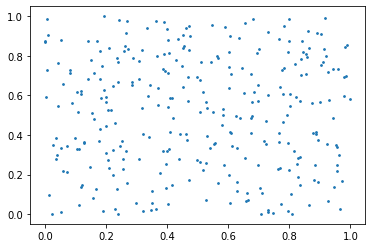

In [2]:
X = np.random.uniform(size=[300,2])
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

In [3]:
st = gd.RipsComplex(points=X, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

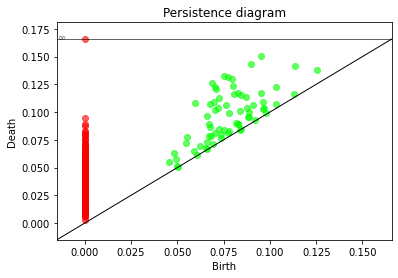

In [4]:
plot = gd.plot_persistence_diagram(dgm)

In [5]:
def compute_persistence(st, card, hom_dim):
    st.persistence()
    pairs = st.persistence_pairs()
    dgm = np.zeros([card[0], 2], dtype=np.float32)
    spl = np.zeros([card[0], 2*hom_dim[0] + 3], dtype=np.int32)
    mask = np.zeros([card[0]], dtype=np.int32)
    count = 0
    for [splx0, splx1] in pairs:
        if len(splx0) - 1 == hom_dim[0] and count < card[0] and len(splx1) > 0:
            dgm[count,0], dgm[count,1] = st.filtration(splx0), st.filtration(splx1)
            spl[count,:hom_dim[0]+1], spl[count,hom_dim[0]+1:] = np.array(splx0), np.array(splx1)
            mask[count] = 1
            count += 1
    return [dgm, spl, mask]

def compute_rips(card, hom_dim, x, Dx, max_length):
    rc = gd.RipsComplex(points=x, max_edge_length=max_length[0])
    st = rc.create_simplex_tree(max_dimension=hom_dim[0]+1)
    return compute_persistence(st, card, hom_dim)

def compute_rips_grad(grad_dgm, dgm, spl, mask, c, h, x, Dx):
    grad_x = np.zeros(x.shape, dtype=np.float32)
    for i in range(c[0]):
        if mask[i] == 1:
            val0, val1 = dgm[i,0], dgm[i,1]
            splx0, splx1 = spl[i,:h[0]+1], spl[i,h[0]+1:]
            D0, D1 = Dx[splx0,:][:, splx0], Dx[splx1,:][:, splx1]
            [v0a, v0b] = list(splx0[np.argwhere(np.abs(D0-val0) <= 1e-4)[0,:]])
            [v1a, v1b] = list(splx1[np.argwhere(np.abs(D1-val1) <= 1e-4)[0,:]])
            if h[0] > 0:
                grad_x[v0a,:] += grad_dgm[i,0] * (x[v0a,:] - x[v0b,:]) / val0
                grad_x[v0b,:] += grad_dgm[i,0] * (x[v0b,:] - x[v0a,:]) / val0
            grad_x[v1a,:] += grad_dgm[i,1] * (x[v1a,:] - x[v1b,:]) / val1
            grad_x[v1b,:] += grad_dgm[i,1] * (x[v1b,:] - x[v1a,:]) / val1
    return grad_x

In [6]:
class Rips(torch.autograd.Function):

    @staticmethod
    def forward(ctx, card, hom_dim, x, max_length):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        x1 = x.reshape((n_pts,1,2))
        x2 = x.reshape((1,n_pts,2))
        Dx = torch.sqrt(torch.sum((x1-x2)**2, axis=2))
        dgm, spl, mask = compute_rips(card, hom_dim, x.detach().numpy(), Dx.detach().numpy(), max_length)
        ctx.dgm = dgm
        ctx.spl = spl
        ctx.card = card
        ctx.hom_dim = hom_dim
        ctx.x = x.detach().numpy()
        ctx.Dx = Dx.detach().numpy()
        return torch.tensor(dgm), torch.tensor(spl), torch.tensor(mask)

    @staticmethod
    def backward(ctx, dgm_grad, spl_grad, mask_grad):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        dgm = ctx.dgm
        spl = ctx.spl
        c = ctx.card
        h = ctx.hom_dim
        x = ctx.x
        Dx = ctx.Dx
        grad_x = compute_rips_grad(dgm_grad.detach().numpy(), dgm, spl, mask, c, h, x, Dx)
        return None, None, torch.FloatTensor(grad_x), None, None


In [7]:
n_pts = 300   # number of points in the point clouds
card  = 50    # max number of points in the diagrams
hom   = 0     # homological dimension
ml    = 12.   # max distance in Rips
lr    = 1e-1  # learning rate
epochs = 100  # number of optimization steps

In [8]:
x = Variable(torch.FloatTensor(n_pts, 2).uniform_(), requires_grad=True)
optimizer = torch.optim.Adam([x], lr=lr)

In [9]:
def sum_diag_loss(dgm):
    loss = -torch.sum((dgm[:,1]-dgm[:,0])**2)
    return loss

In [10]:
Rips = Rips.apply

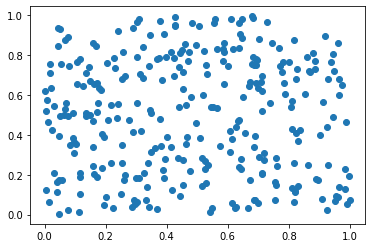

In [11]:
plt.scatter(x.detach().numpy()[:,0], x.detach().numpy()[:,1])
plt.show()

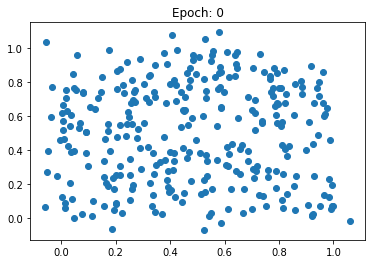

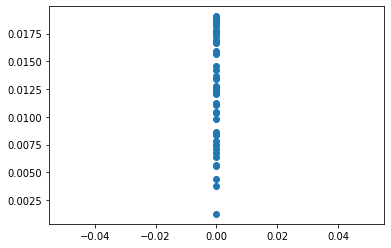

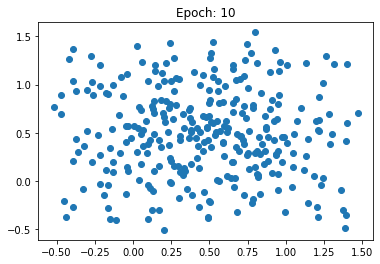

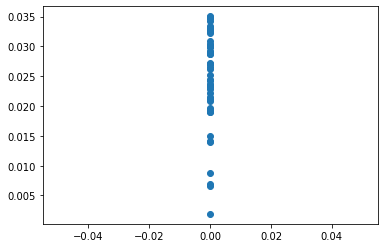

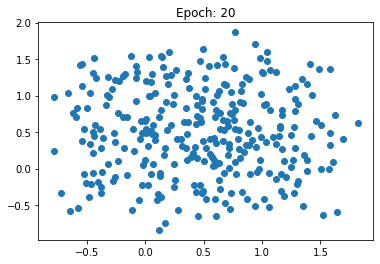

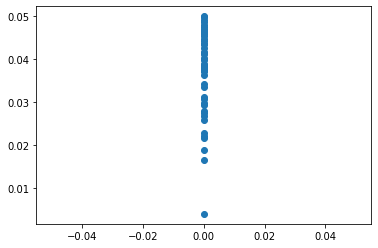

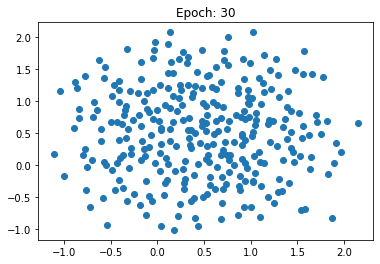

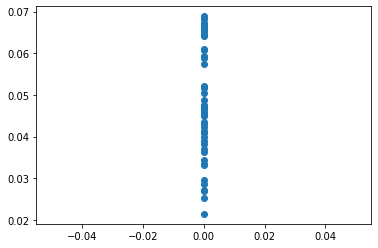

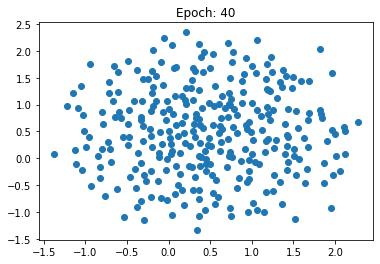

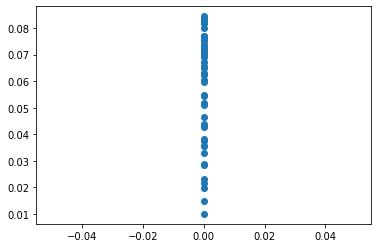

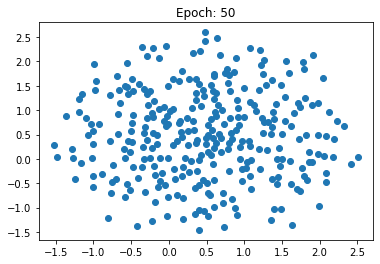

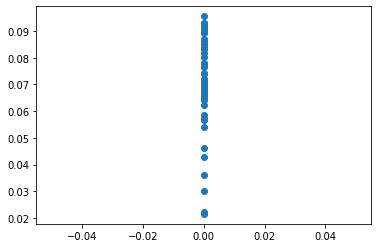

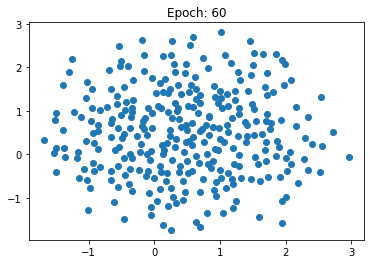

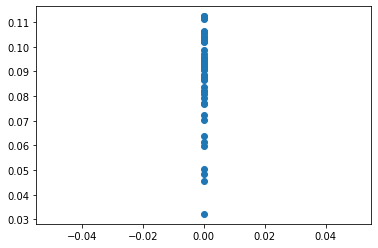

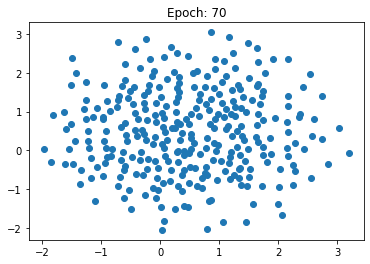

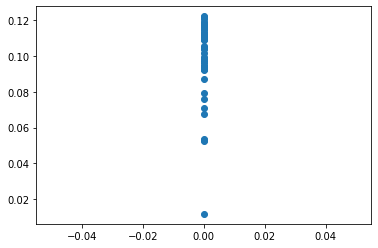

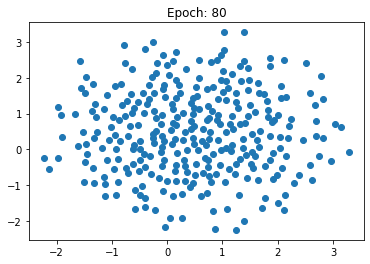

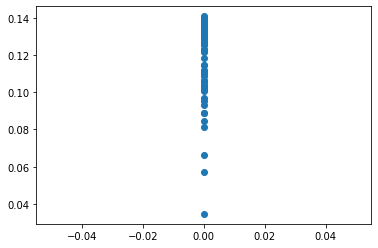

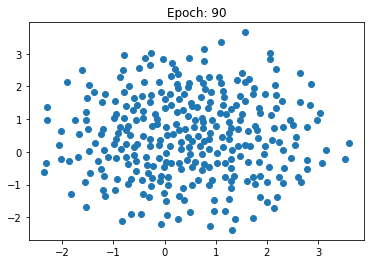

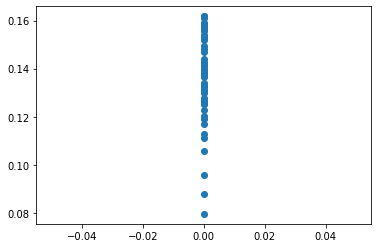

In [12]:
for i in range(epochs):
    optimizer.zero_grad()
    dgm, spl, mask = Rips(np.array([card],dtype=np.int32),np.array([hom],dtype=np.int32), \
                          x,np.array([ml],dtype=np.float32))
    loss = sum_diag_loss(dgm)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        plt.figure()
        plt.scatter(x.detach().numpy()[:,0], x.detach().numpy()[:,1])
        plt.title('Epoch: {}'.format(i))
        plt.show()
        plt.figure()
        plt.scatter(dgm.detach().numpy()[:,0],dgm.detach().numpy()[:,1])
        plt.show()